# Summary

This notebook will explore the LMP data from the NYISO website.

Questions to answer:
- How is the congestion data distributed?
- What time of year is congestion most likely to occur?
- What are the most congested pricing points?
- Which pricing points have the longest sustained congestion?
- Which pricing points are traded the most in FTRs?

In [ ]:
import calendar
import datetime

import gridstatus
import gridstatus.nyiso as nyiso
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

from adhoc_energy_analytics.constants import get_default_processed_dir
from adhoc_energy_analytics.stats import freedman_diaconis_bins, trim_by_index

pd.set_option("display.float_format", "{:.5f}".format)

nyiso = gridstatus.NYISO()

# Download the NYISO LMP data for the past 3 years

* I am assuming 2022-2025 is an acceptable "post-pandemic" period.

In [61]:
from dateutil.relativedelta import relativedelta


def download_lmp_by_month(
    start_date: datetime.date, end_date: datetime.date
) -> pd.DataFrame:
    """
    Download NYISO LMP data one month at a time between start_date and end_date.
    Each month's data is saved as a separate parquet file in the default processed dir.
    Returns a concatenated DataFrame of all months.
    """
    processed_dir = get_default_processed_dir()
    processed_dir.mkdir(parents=True, exist_ok=True)

    current = datetime.date(start_date.year, start_date.month, 1)
    last = datetime.date(end_date.year, end_date.month, 1)

    dfs = []
    while current <= last:
        next_month = current + relativedelta(months=1)
        month_end = next_month - datetime.timedelta(seconds=1)

        out_path = processed_dir / f"nyiso_lmp_{current:%Y_%m}.parquet"
        if out_path.exists():
            print(f"Loading existing file {out_path}")
            df_month = pd.read_parquet(out_path)
        else:
            print(f"Downloading LMP data for {current:%Y-%m} to {out_path}")
            df_month = nyiso.get_lmp(
                date=current,
                end=month_end,
                market=gridstatus.Markets.DAY_AHEAD_HOURLY,
                locations="ALL",
                location_type=gridstatus.nyiso.GENERATOR,
                verbose=False,
            )
            df_month.to_parquet(out_path)

        dfs.append(df_month)
        current = next_month

    print(f"Concatenating {len(dfs)} months of data")
    return pd.concat(dfs, ignore_index=True)


# example invocation
start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2025, 1, 1) - datetime.timedelta(days=1)
df = download_lmp_by_month(start_date, end_date)

Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2022_01.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2022_02.parquet
Loading existing file /Users/hankehly/Projects/adhoc-energy-analytics/data/processed/nyiso_lmp_2022_03.parquet
Concatenating 96 months of data


In [62]:
df = all_lmp_df

# How is the congestion data distributed?

Congestion is heavily skewed to the right, with more than 50% of values being less than 1.

In [63]:
df.Congestion.describe()

count   42057054.00000
mean           7.08454
std           16.72247
min         -823.22000
25%            0.00000
50%            0.82000
75%            7.73000
max         2210.33000
Name: Congestion, dtype: float64

In [64]:
trimmed_df = trim_by_index(df, trim_col="Congestion", lower_pct=0.1, upper_pct=0.1)
trimmed_vals = trimmed_df.Congestion

In [65]:
trimmed_vals.describe()

count   33645643.00000
mean           3.55984
std            5.05722
min           -0.00000
25%           -0.00000
50%            0.82000
75%            5.61000
max           20.43000
Name: Congestion, dtype: float64

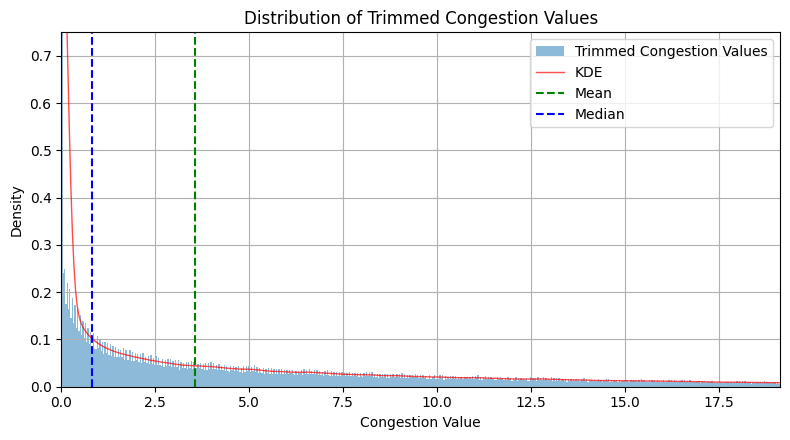

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# Histogram of trimmed congestion values
bins = freedman_diaconis_bins(trimmed_vals)
ax.hist(
    trimmed_vals, bins=bins, density=True, alpha=0.5, label="Trimmed Congestion Values"
)

# KDE overlay
trimmed_vals.plot(kind="kde", ax=ax, color="red", linewidth=1, label="KDE", alpha=0.7)

# Mean & median lines
ax.axvline(trimmed_vals.mean(), color="green", linestyle="dashed", label="Mean")
ax.axvline(trimmed_vals.median(), color="blue", linestyle="dashed", label="Median")

# Axis limits, labels, title, legend, grid
ax.set_xlim(trimmed_vals.min(), trimmed_vals.quantile(0.99))
ax.set_ylim(0, 0.75)
ax.set_title("Distribution of Trimmed Congestion Values")
ax.set_xlabel("Congestion Value")
ax.set_ylabel("Density")
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

# How has congestion increased/decreased over the past several years?

There was a significant increase in congestion starting around 2021, lasting through mid-2023. The reasons for congestion varied by year and highlights how many factors can contribute to congestion. The main reasons I could find for increased congestion revenues in the above timeframe are:
* Gas prices contributed to price spreads between regions, which increased redispatch costs to resolve congestion.
* Transmission outages to facilitate public policy projects
* Retirement of Indian Point nuclear station
* Transmission outages on tie lines between Long Island and upstate regions

In **2021**, congestion increased because of higher redispatch costs due to increased gas prices, bottlenecks from transmission upgrades, the [Indian Point nuclear station](https://en.wikipedia.org/wiki/Indian_Point_Energy_Center) retirement on April 30 and tie line outages. From the [2021 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2022/05/NYISO-2021-SOM-Full-Report_5-11-2022-final.pdf):

> Real-time prices varied from an average of $24.10 per MWh in the North Zone to $62.24 per MWh in Long Island in 2021 because of the effects of transmission congestion and losses. (See Section II.A) Average energy prices rose substantially from 2020 to 2021, up 72 to 78 percent in Western New York and 92 to 104 percent in Eastern New York. The increases across the system were driven primarily by higher natural gas prices. The larger increase in Eastern New York was mostly attributable to more severe transmission bottlenecks across the Central-East interface because of lengthy transmission outages taken to facilitate several Public Policy Transmission Projects and the retirements of Indian Point nuclear units. In addition, Long Island experienced lengthy transmission outages on both of its tie lines with upstate regions, leading to abnormally high levels of congestion and elevated energy prices on Long Island.
> 
> Consequently, congestion revenues collected in the day-ahead market rose 86 percent from 2020, totaling $551 million in 2021. (See Section VI.A) The following corridors accounted for most of the congestion in 2021:
> * Central-East Interface – 56 percent
> * Long Island – 12 percent
> * West Zone (flowing east) – 9 percent
> * North to Central New York – 6 percent
> * New York City – 6 percent

From section II.A of the report:

> Transmission congestion increased on paths from north-to-central New York, from central-to-eastern New York, and from upstate into Long Island. These increases were driven primarily by lengthy planned policy-driven transmission outages, the Indian Point 3 retirement at the end of April, and forced outages of key transmission lines during the summer months (especially into Long Island).

From section VII of the report:
> Higher natural gas prices and gas price spreads between regions, which increase redispatch costs to resolve congestion, were one of the main drivers of elevated congestion levels in 2021.

In **2022**, congestion rose *again* due to higher gas prices and more lengthy transmission outages for AC public policy projects.

From the [2022 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2023/05/NYISO-2022-SOM-Full-Report__5-16-2023-final.pdf):

> Real-time prices varied from an average of $50.46 per MWh in the North Zone to $108 per MWh in Long Island in 2022 because of transmission congestion and losses. (See Section II.A) Average energy prices rose substantially from 2021 to 2022, up 83 to 109 percent in Western New York and 73 to 126 percent in Eastern New York, primarily because of higher natural gas prices. The larger increases in eastern New York was largely attributable to: (a) more severe transmission bottlenecks across the Central-East interface due to lengthy transmission outages taken to facilitate the AC Public Policy Transmission Projects, and (b) larger gas price increases in eastern New York during the winter months.
> Consequently, congestion revenues collected in the day-ahead market rose 82 percent from 2021, totaling $1 billion in 2022. (See Section VI.A) The following corridors accounted for most congestion in 2022:
> * Central-East Interface – 60 percent
> * External Interfaces – 9 percent
> * Long Island – 9 percent

More from section II.A of the report:

> Transmission congestion became more severe, especially from Central New York to East New York and from upstate into Long Island, primarily because of lengthy forced transmission outages and planned outages related to ongoing efforts to upgrade segments of the transmission system. More is written on congestion patterns in Section VII.

In **2023**, congestion fell because gas prices went down, and the transmission projects from 2021-2022 completed (thereby reducing outages) and as a result there was increased transmission capability. Also, the mild winter weather helped reduce congstion on gas pipelines.

From the [2023 STATE OF THE MARKET REPORT FOR THE NEW YORK ISO MARKETS](https://www.potomaceconomics.com/wp-content/uploads/2024/05/NYISO-2023-SOM-Full-Report__5-13-2024-Final.pdf):

> Average energy prices fell substantially from 2022 in Western New York (53 to 57 percent) and Eastern New York (58 to 65 percent) mainly because of lower gas prices and fewer transmission outages. Transmission congestion and losses in 2023 caused real-time prices to vary from $23.50 per MWh in the North Zone to $45.38 in Long Island on average. (See Section II.A)
>
> Price reductions were larger in eastern New York because transmission bottlenecks across the Central-East interface were alleviated by: (a) fewer planned transmission outages related to construction of the AC Public Policy Transmission Projects, (b) the increased transfer capability from the newly-built projects, and (c) mild winter weather conditions which helped reduce congestion on gas pipelines flowing into eastern New York. Consequently, congestion revenues collected in the day-ahead market fell 69 percent from 2022, totaling $311 million in 2023. (See Section VI.A) Most congestion in 2023 occurred on two corridors: the Central-East Interface (53 percent of all congestion) and Long Island (19 percent of all congestion).

From section VII of the report:
> Day-ahead congestion revenues fell to $311 million in 2023, marking a 69 percent decrease from 2022 and nearing the lowest level observed ($297 million) over the past decade. The sharp reduction in congestion was primarily attributable to lower natural gas prices and narrower gas price spreads between regions, which led to lower redispatch costs.
>
> Congestion was also reduced by less frequent planned transmission outages in 2023 than during the construction of major transmission projects over the past two years. As major transmission upgrades have been completed, congestion in the affected regions has been greatly reduced.

... etc.

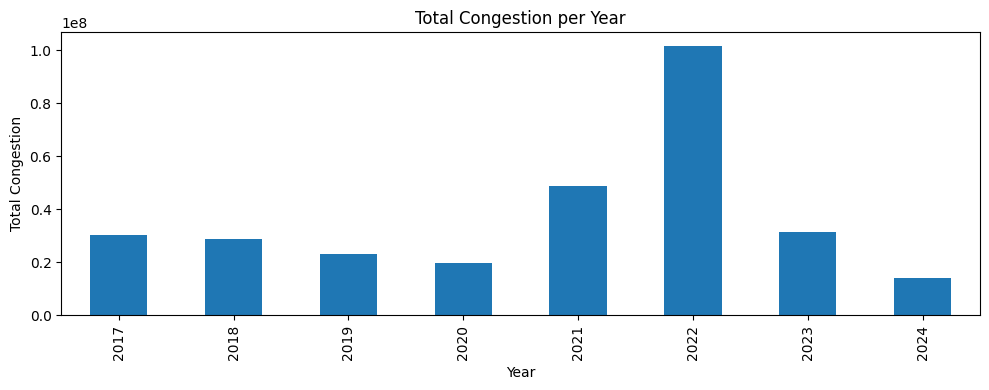

In [70]:
# What is the total congestion per year?
yearly_totals = df.groupby(df["Interval Start"].dt.year)["Congestion"].sum()

fig, ax = plt.subplots(figsize=(10, 4))
yearly_totals.plot(kind="bar", ax=ax)
ax.set_title("Total Congestion per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Total Congestion")
plt.tight_layout()
plt.show()

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_54009/1232962730.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.groupby(df["Interval Start"].dt.to_period("M"))["Congestion"].sum().reset_index()


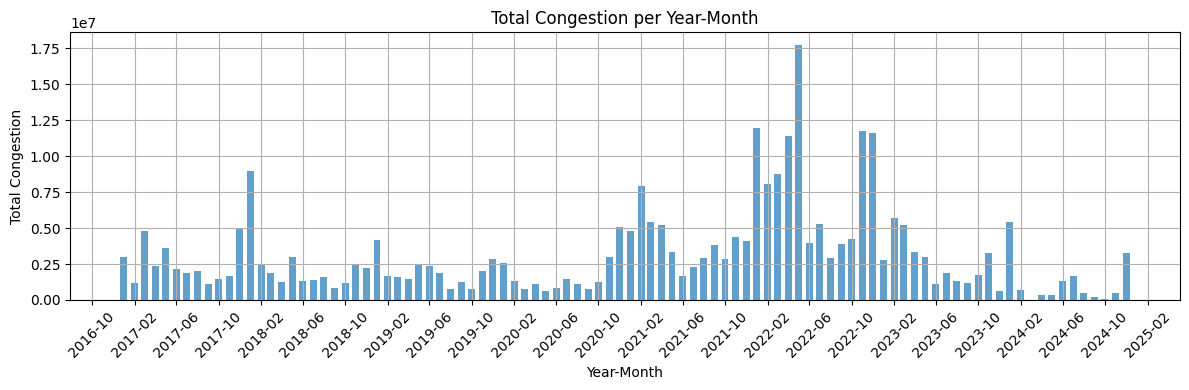

In [93]:
# Aggregate data
sum_cong_per_year_month = (
    df.groupby(df["Interval Start"].dt.to_period("M"))["Congestion"].sum().reset_index()
)
sum_cong_per_year_month["Interval Start"] = sum_cong_per_year_month[
    "Interval Start"
].dt.to_timestamp()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(
    sum_cong_per_year_month["Interval Start"],
    sum_cong_per_year_month["Congestion"],
    width=20,
    alpha=0.7,
)

# Format the x-axis: show a tick every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.tick_params(axis="x", rotation=45)

ax.set_xlabel("Year-Month")
ax.set_ylabel("Total Congestion")
ax.set_title("Total Congestion per Year-Month")
ax.grid()

plt.tight_layout()
plt.show()

# What time of year is congestion most likely to occur?

It looks like congestion in 2024 occurred most frequently in the summer and winter months.

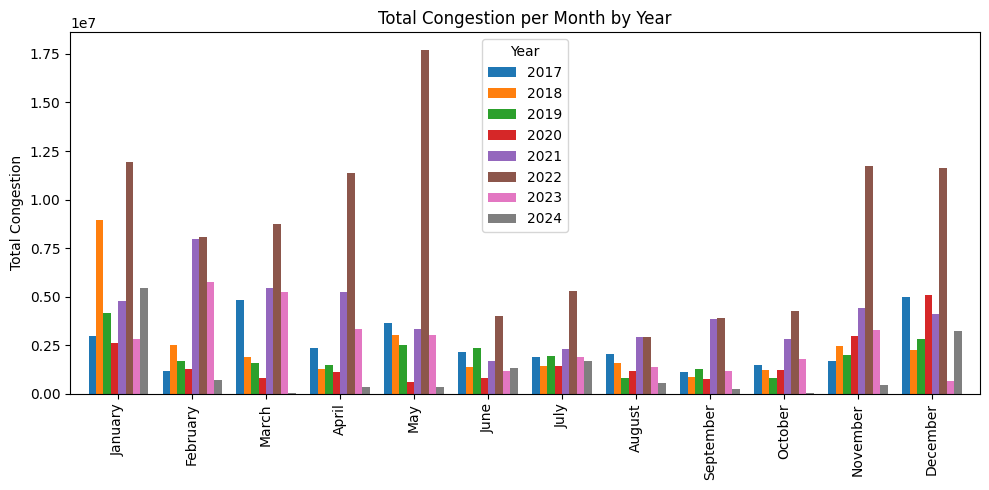

In [125]:
# total congestion by year-month
monthly_yearly = (
    df.groupby([df["Interval Start"].dt.year, df["Interval Start"].dt.month])[
        "Congestion"
    ]
    .sum()
    .unstack(level=0)
)

# label the index with month names
monthly_yearly.index = [calendar.month_name[m] for m in monthly_yearly.index]

fig, ax = plt.subplots(figsize=(10, 5))
monthly_yearly.plot(kind="bar", ax=ax, width=0.8)
ax.set_title("Total Congestion per Month by Year")
ax.set_ylabel("Total Congestion")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

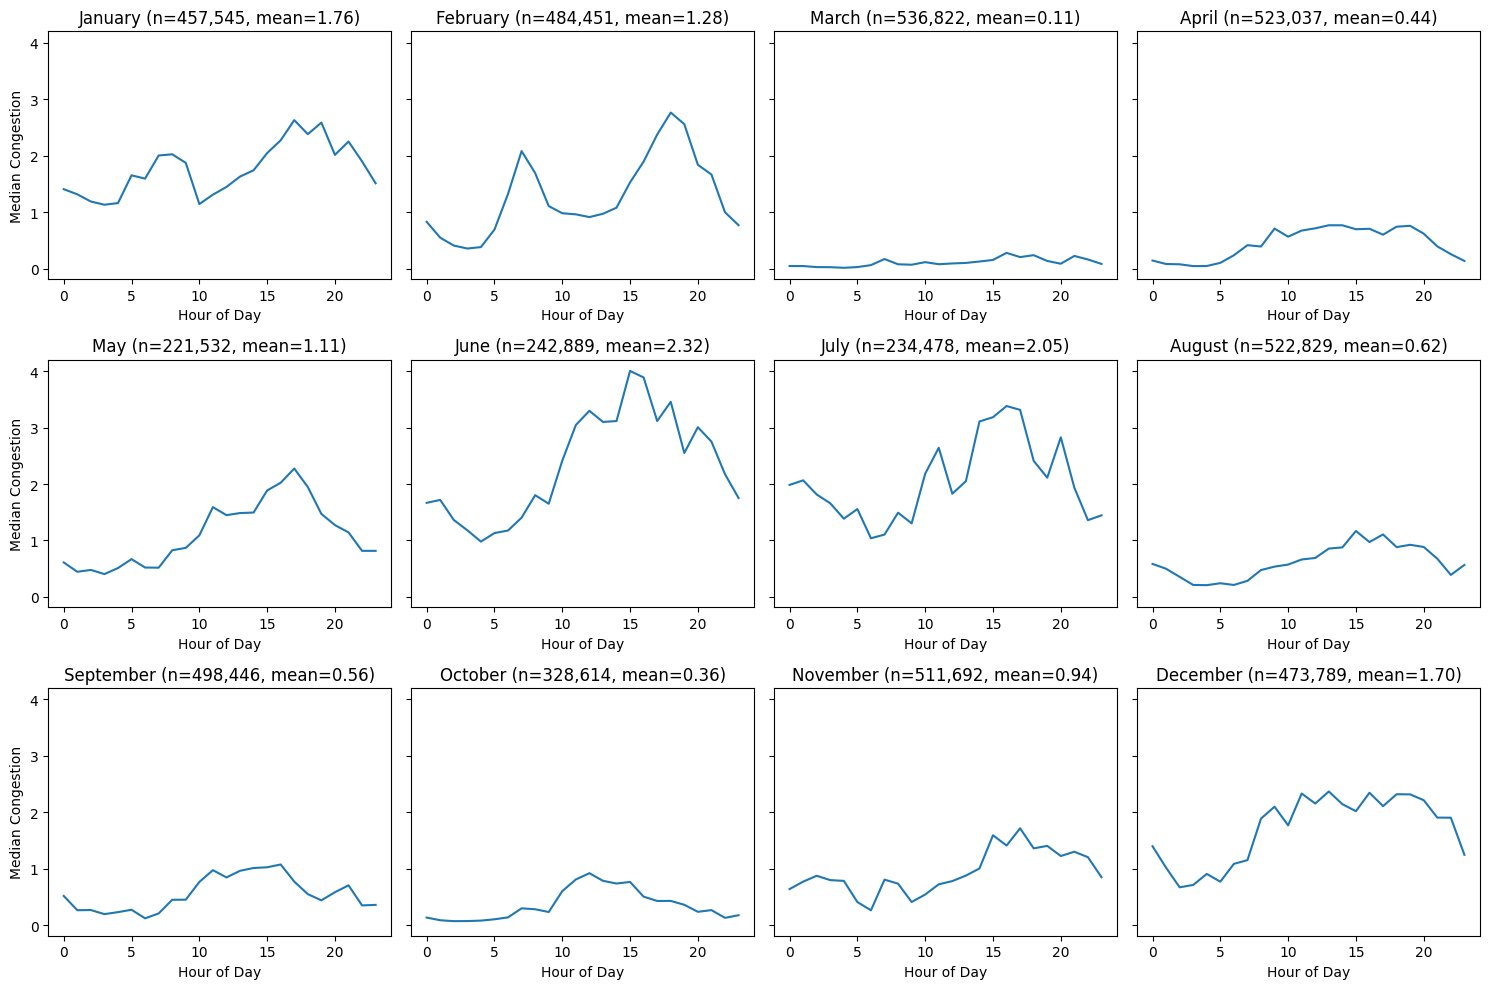

In [126]:
trimmed_df_2024 = trimmed_df[trimmed_df["Interval Start"].dt.year == 2024]

# get counts per month
counts = trimmed_df_2024["Interval Start"].dt.month.value_counts().sort_index()

fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharey=True)
axes = axes.flatten()

mean_cong_month_hour = trimmed_df_2024.pivot_table(
    index=trimmed_df_2024["Interval Start"].dt.hour,
    columns=trimmed_df_2024["Interval Start"].dt.month,
    values="Congestion",
    aggfunc="mean",
)

for month, ax in zip(mean_cong_month_hour.columns, axes):
    # plot the mean congestion curve
    mean_cong_month_hour[month].plot(ax=ax)
    # annotate title with month name and count
    n = counts.get(month, 0)
    ax.set_title(
        f"{calendar.month_name[month]} (n={n:,}, mean={mean_cong_month_hour[month].mean():.2f})"
    )
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Median Congestion")

plt.tight_layout()
plt.show()